In [23]:
import numpy as np
import pandas as pd
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import warnings

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                            GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.model_selection import KFold

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

PassengerId = test['PassengerId']




In [24]:
full_data = [train, test]


In [25]:
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] =1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)


In [26]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std,
                                             age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)



/home/ma/.bin/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]"


In [28]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)

    if title_search:
        return title_search.group(1)
    return ""


In [29]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt',\
                                                'Col', 'Dr','Major', 'Rev', 'Sir',\
                                                'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace("Mlle", 'Miss')
    dataset['Title'] = dataset['Title'].replace("Ms", "Miss")
    dataset['Title'] = dataset['Title'].replace("Mme", 'Mrs')


In [30]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    int64  
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Name_length  418 non-null    int64  
 12  Has_Cabin    418 non-null    int64  
 13  FamilySize   418 non-null    int64  
 14  IsAlone      418 non-null    int64  
 15  Title        418 non-null    object 
dtypes: float64(1), int64(9), object(6)
memory usage: 52.4+ KB


In [32]:
test['Age'].isnull().sum()

0

In [33]:
for  dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)

    title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master": 4, "Rare":5}

    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title']= dataset['Title'].fillna(0)

    dataset["Embarked"] = dataset['Embarked'].map({"S":0, "C":1, "Q":2}).astype(int)

    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ (dataset['Fare'] > 31) , 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset.loc[ (dataset['Age'] <= 16), 'Age'] = 0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] =1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] =2
    dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] =3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4;



In [34]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', "CategoricalFare"], axis=1)
test = test.drop(drop_elements, axis=1)


<AxesSubplot:title={'center':'Person Correlation of Feaure'}>

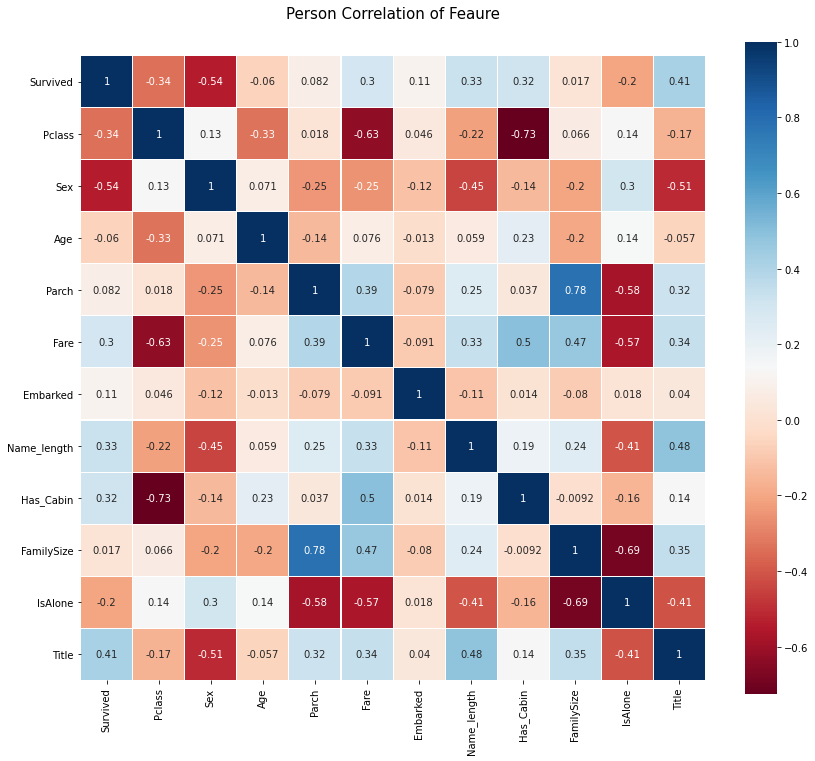

In [35]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Person Correlation of Feaure', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor="white", annot=True)


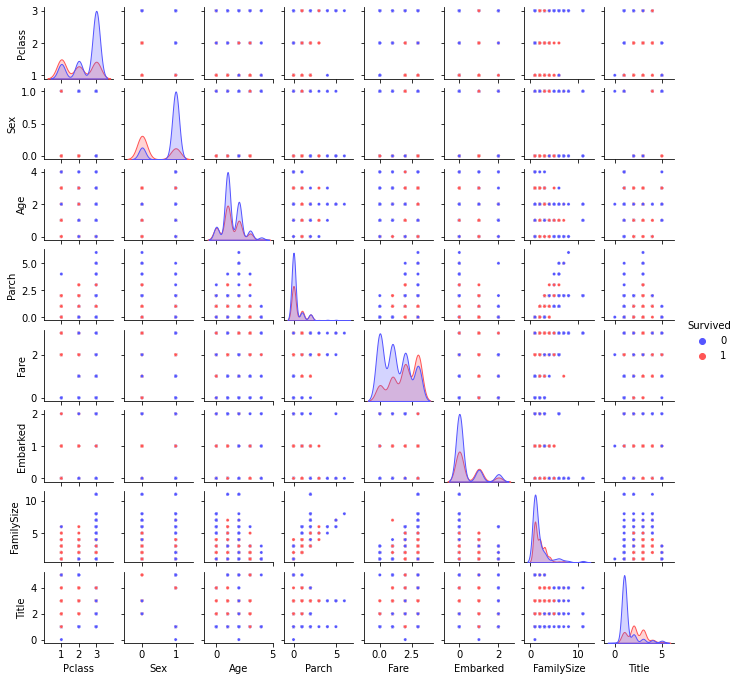

In [41]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch',
                        u'Fare', u'Embarked', u'FamilySize', u'Title']], hue='Survived',
                        palette='seismic', height=1.2, diag_kind='kde', diag_kws=dict(shade=True),
                        plot_kws=dict(s=10))




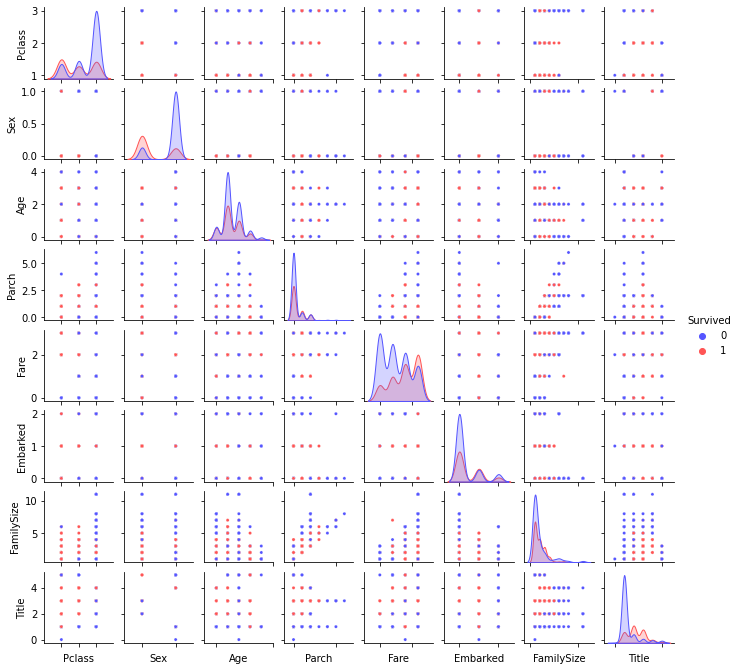

In [42]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch',
                        u'Fare', u'Embarked', u'FamilySize', u'Title']], hue='Survived',
                        palette='seismic', height=1.2, diag_kind='kde', diag_kws=dict(shade=True),
                        plot_kws=dict(s=10))
g.set(xticklabels=[])


In [44]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS)
kf.get_n_splits(train)

class SklernHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)



In [45]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)



In [46]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}


et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf':2,
    'verbose': 0
}

svc_params = {
    'kernel': 'linear',
    'C': 0.025
}



In [50]:
rf = SklernHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklernHelper(clf=ExtraTreesClassifier, seed = SEED, params=et_params)
ada = SklernHelper(clf=AdaBoostClassifier,seed= SEED, params= ada_params)
gb = SklernHelper(clf=GradientBoostingClassifier, seed=SEED, params= gb_params)
svc = SklernHelper(clf=SVC, seed=SEED, params= svc_params)



In [51]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values


KeyError: 'Survived'

In [52]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)


/home/ma/.bin/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:368: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

/home/ma/.bin/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:368: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

/home/ma/.bin/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:368: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

/home/ma/.bin/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:368: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



In [53]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)


/home/ma/.bin/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:368: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



[0.12629277 0.20201187 0.03030655 0.02138056 0.07090112 0.02388562
 0.10892314 0.06474076 0.06736348 0.01305753 0.27113661]
[0.12202753 0.38841145 0.02870238 0.01668885 0.05497165 0.02797863
 0.04867583 0.08392997 0.04456175 0.02163546 0.1624165 ]
[0.03  0.01  0.02  0.064 0.036 0.008 0.692 0.012 0.048 0.008 0.072]
[0.1156529  0.01177074 0.05091065 0.00928621 0.04671049 0.02443364
 0.18334228 0.03616009 0.08675878 0.00673288 0.42824133]


In [54]:
train.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,0,2,0,3,1,51,1,2,0,3.0
2,3,0,1,0,1,0,22,0,1,1,2.0
3,1,0,2,0,3,0,44,1,2,0,3.0
4,3,1,2,0,1,0,24,0,1,1,1.0
